In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from tqdm.notebook import tqdm
import os
import operator
from scipy.stats import spearmanr

In [2]:
def load_cosmic_genes(cosmic_infile):
    with open(cosmic_infile, 'r') as f:
        return [line.split()[0] for line in f.readlines()[1:]]
    
def prep_file_paths(key):
    paths_raw = glob.glob(key)
#     print(paths_raw)

    dict_paths = {}
    for filename in paths_raw:

        directory, file_core = os.path.split(filename)

        if file_core.startswith('cc'):
            num_genes = int(file_core.split('_')[1][1:])
            dict_paths[num_genes] = filename

    sorted_dict = sorted(dict_paths.items(), key=operator.itemgetter(0))

#     paths = []
#     for i in range(len(sorted_dict)):
#         paths.append(sorted_dict[i][1])
        
    return dict_paths
def get_genes_set(filename):
    '''get n genes from mexcowalk result'''
    with open(filename) as f:
        return set([g for line in f.readlines() for g in line.split()])
    
def get_cosmic_genes_set(filename,ref_genes):
    '''get cosmic genes from mexcowalk result'''
    with open(filename) as f:
        genes = set([g for line in f.readlines() for g in line.split()])
    return set.intersection(genes,set(ref_genes))
        
def get_cosmic_overlap(filename,ref_genes):
    '''get cosmic overlap for a single model and a single cc_n file'''
    with open(filename) as f:
        genes = set([g for line in f.readlines() for g in line.split()])
    return len(set.intersection(genes,set(ref_genes)))

def cosmic_analysis(c,t,mutex_methods,models,inpath):
    '''get cosmic overlap for models for a single cancer type'''
    cols = ['orig', 'discover','fishers', 'wext', 'cov_only']
    d_main = {m:{} for m in models}
    for m in tqdm(models):
        print(m)
        paths = prep_file_paths(inpath+m+'/*')

        #for each n and resp. path
        for k,path in sorted(paths.items()):
            d_main[m][k] = get_cosmic_overlap(path,cosmic_genes)

    df = pd.DataFrame.from_dict(d_main)
    df.columns = cols
    return df

In [3]:
#cosmic
cosmic_infile = '../data/Census_allFri_Apr_26_12_49_57_2019.tsv'
cosmic_genes = load_cosmic_genes(cosmic_infile)
cosmic_genes[:5]

['A1CF', 'ABI1', 'ABL1', 'ABL2', 'ACKR3']

In [4]:
inpath = '../out/connected_components_isolarge/'
methods = ['orig','discover','fishers','wext']

c = 'LUSC'
t = 5

models = ['{}_{}_mexcowalk_t{}'.format(c,m,t) for m in methods] + ['{}_mexcowalk_cov_t{}'.format(c,t)]

df = cosmic_analysis(c,t,methods,models,inpath)
df

LUSC_orig_mexcowalk_t5
LUSC_discover_mexcowalk_t5
LUSC_fishers_mexcowalk_t5
LUSC_wext_mexcowalk_t5
LUSC_mexcowalk_cov_t5



orig  discover  fishers  wext  cov_only
100     16        18       18    17        16
200     30        30       33    29        32
300     40        49       47    46        42
400     52        63       63    60        58
500     67        75       81    71        73
600     84        91       97    96        84
700     93       105      106   101        93
800    100       119      117   117       106
900    117       135      131   124       113
1000   131       152      145   136       130

In [5]:
c = 'COADREAD'
t = 5

models = ['{}_{}_mexcowalk_t{}'.format(c,m,t) for m in methods] + ['{}_mexcowalk_cov_t{}'.format(c,t)]

df = cosmic_analysis(c,t,methods,models,inpath)
df

COADREAD_orig_mexcowalk_t5
COADREAD_discover_mexcowalk_t5
COADREAD_fishers_mexcowalk_t5
COADREAD_wext_mexcowalk_t5
COADREAD_mexcowalk_cov_t5



orig  discover  fishers  wext  cov_only
100     17        24       15    22        19
200     31        41       28    40        28
300     45        47       42    50        49
400     55        58       51    59        57
500     63        71       56    71        71
600     74        82       65    83        81
700     85        98       74   103        95
800     96       114       82   113       106
900    106       124       91   126       118
1000   116       133      102   135       129

## Get gene overlap for between discover, fishers and wext

In [44]:
## get cgc genes fisher finds that other models dont find

c = 'UCEC'
t = 5

dict_inpath = {'discover': '../../version y - DISCOVER orig/',
               'discover_strat': '../../version y - DISCOVER orig/',
               'fishers': '../../version yi - FISHERS EXACT/',
               'megsa': '../../version yiii - MEGSA/',
               'memo': '../../version yii - MEMO/memo/',
               'wext': '../../version yiv - WEXT/'
              }

current_methods = methods[1:]

## assign method paths to a dict
dict_infile = {}
dict_infile_intact = {}
for m in current_methods:
    if m == 'discover':
        suffix = 'out/{}_mutation_filtered_ep_data/{}_{}_result_mutations_all_genes_q1.0_normal_{}.txt'.format(m,c,m,t)
        suffix_intact = 'out/{}_mutation_filtered_ep_data/{}_pairs_q1.0_normal_intact_filtered_subset{}.txt'.format(m,c,t)
    elif m == 'discover_strat':
        suffix = 'out/{}_mutation_filtered_ep_data/{}_{}_result_mutations_all_genes_q1.0_stratified_{}.txt'.format('discover',c,'discover',t)
        suffix_intact = 'out/{}_mutation_filtered_ep_data/{}_pairs_q1.0_stratified_intact_filtered_subset{}.txt'.format('discover',c,t)    
    else:
        suffix = 'out/{}_mutation_filtered_ep_data/{}_{}_result_mutations_all_genes_{}.txt'.format(m,c,m,t)
        suffix_intact = 'out/{}_mutation_filtered_ep_data/{}_{}_pairs_intact_filtered_subset{}.txt'.format(m,c,m,t)

    dict_infile[m] = dict_inpath[m] + suffix
    dict_infile_intact[m] = dict_inpath[m] + suffix_intact

## model names 
models = ['{}_{}_mexcowalk_t{}'.format(c,m,t) for m in methods] + ['{}_mexcowalk_cov_t{}'.format(c,t)]

d_main = {m:{} for m in models}
for m in tqdm(models):
    print(m)
    paths = prep_file_paths(inpath+m+'/*')

    #for each n and resp. path
    for k,path in sorted(paths.items()):
        d_main[m][k] = get_cosmic_genes_set(path,cosmic_genes)
        
d_main

COADREAD_orig_mexcowalk_t5
COADREAD_discover_mexcowalk_t5
COADREAD_fishers_mexcowalk_t5
COADREAD_wext_mexcowalk_t5
COADREAD_mexcowalk_cov_t5



{'COADREAD_orig_mexcowalk_t5': {100: {'ALK',
   'AMER1',
   'ANK1',
   'APC',
   'CHD4',
   'CNTNAP2',
   'CTNND2',
   'GRIN2A',
   'KDM5C',
   'KRAS',
   'MYH11',
   'PDE4DIP',
   'PTPN13',
   'RALGDS',
   'ROBO2',
   'SETBP1',
   'TNC'},
  200: {'ALK',
   'AMER1',
   'ANK1',
   'APC',
   'ARAF',
   'CHD4',
   'CNTNAP2',
   'CREBBP',
   'CTNND2',
   'ERBB3',
   'FBXW7',
   'FLNA',
   'GRIN2A',
   'HNF1A',
   'KDM5C',
   'KRAS',
   'MYH11',
   'NCOR2',
   'NUP98',
   'PBRM1',
   'PDE4DIP',
   'PIK3CA',
   'PTPN13',
   'PTPRT',
   'RALGDS',
   'RANBP2',
   'ROBO2',
   'SETBP1',
   'TNC',
   'TP53',
   'TRRAP'},
  300: {'ALK',
   'AMER1',
   'ANK1',
   'APC',
   'ARAF',
   'ARID1A',
   'ARID2',
   'ATM',
   'BRAF',
   'CHD4',
   'CNTNAP2',
   'CNTRL',
   'CREBBP',
   'CTNNB1',
   'CTNND2',
   'EPHA3',
   'EPHA7',
   'ERBB3',
   'ERBB4',
   'FBXW7',
   'FLNA',
   'GRIN2A',
   'HNF1A',
   'KDM5C',
   'KRAS',
   'MTOR',
   'MYH11',
   'NCOR2',
   'NRAS',
   'NUP214',
   'NUP98',
   'PBRM1',

In [45]:
models

['COADREAD_orig_mexcowalk_t5',
 'COADREAD_discover_mexcowalk_t5',
 'COADREAD_fishers_mexcowalk_t5',
 'COADREAD_wext_mexcowalk_t5',
 'COADREAD_mexcowalk_cov_t5']

In [47]:
## get genes in fisher but not rest
with open('../out/genes_exclusively_in_fishers/{}_t{}_cc_n_genes_exclusively in fishers.txt'.format(c,t), 'w') as f:
    f.write('n\tgene_count\tgenes\n')
    for n in range(100,1100,100):
        f.write('{}\t'.format(n))
        ##combined discover and wext genes
        dw_genes = d_main['{}_{}_mexcowalk_t{}'.format(c,'discover',t)][n].union(d_main['{}_{}_mexcowalk_t{}'.format(c,'wext',t)][n])
        #fishers exclusive genes (dw-f)
        f_excl_genes = d_main['{}_{}_mexcowalk_t{}'.format(c,'fishers',t)][n] -dw_genes
        f.write(str(len(f_excl_genes))+ '\t'+'\t'.join(sorted(f_excl_genes)) + '\n')

In [20]:
genes_fisher_minus_discover = set()
genes_fisher_minus_wext = set()

for n in range(100,1100,100):
    genes_fisher_minus_discover.update(d_main[models[2]][n]-d_main[models[1]][n])
    genes_fisher_minus_wext.update(d_main[models[2]][n]-d_main[models[3]][n])  
    
print('fishers_discover', len(genes_fisher_minus_discover), genes_fisher_minus_discover,'\n')
print('fishers_wext', len(genes_fisher_minus_wext),genes_fisher_minus_wext)

fishers_discover 58 {'EWSR1', 'ALDH2', 'AXIN1', 'SMC1A', 'BCL6', 'CUX1', 'CXCR4', 'SETDB1', 'ZNRF3', 'MAP3K1', 'GOPC', 'WT1', 'KAT7', 'SMARCA4', 'MLH1', 'CBL', 'PCBP1', 'CTCF', 'DCTN1', 'CCDC6', 'ARHGAP26', 'MAF', 'MED12', 'AKAP9', 'FNBP1', 'TGFBR2', 'CDC73', 'BARD1', 'NUP98', 'DROSHA', 'PPP6C', 'ELF3', 'HLA-A', 'RAF1', 'PBX1', 'GPC5', 'JAK3', 'HNF1A', 'SMARCB1', 'BRD4', 'GAS7', 'GNAQ', 'KMT2C', 'TSC2', 'WRN', 'NFATC2', 'TBX3', 'PPP2R1A', 'DNMT3A', 'MLLT3', 'RBM10', 'FANCC', 'AXIN2', 'MSN', 'B2M', 'PTEN', 'SOX2', 'KTN1'} 

fishers_wext 55 {'EWSR1', 'ALDH2', 'AXIN1', 'SMC1A', 'BCL6', 'CUX1', 'CXCR4', 'SETDB1', 'ZNRF3', 'MAP3K1', 'GOPC', 'WT1', 'KAT7', 'SMARCA4', 'MLH1', 'CBL', 'PCBP1', 'CTCF', 'DCTN1', 'CCDC6', 'ARHGAP26', 'MAF', 'MED12', 'AKAP9', 'PPP6C', 'FNBP1', 'TGFBR2', 'CDC73', 'BARD1', 'ELF3', 'HLA-A', 'RAF1', 'PBX1', 'GPC5', 'JAK3', 'HNF1A', 'SMARCB1', 'BRD4', 'GAS7', 'GNAQ', 'KMT2C', 'TSC2', 'WRN', 'NFATC2', 'TBX3', 'PPP2R1A', 'DNMT3A', 'MLLT3', 'RBM10', 'FANCC', 'AXIN2', 'MSN'

In [21]:
# ## write exlusive genes to file
# with open('../out/{}_t{}_genes_exclusively_in_fishers.txt'.format(c,t), 'w') as f:
#     for g in sorted(genes_fisher_minus_discover.intersection(genes_fisher_minus_wext)):
#         f.write(g+'\n')

In [126]:
merged_file = '../out/mutex_normalized/merged/{}_t{}_mutex_discover_fishers_wext.txt'.format(c,t)
df_fishers = pd.read_csv(merged_file,sep='\t')
df_fishers.rename( columns={'Unnamed: 0':'gene1','Unnamed: 1':'gene2'}, inplace=True )
df_fishers

gene1  gene2  discover   fishers      wext
0      MAP2K1   BRAF  0.049646  0.000042  0.035058
1         MAX    MYC  0.083377  0.020005  0.069174
2       PTPN1   INSR  0.033838  0.000459  0.025988
3       RPTOR   MTOR  0.090852  0.000266  0.066534
4       CCNT1   CDK9  0.005823  0.000026  0.004558
...       ...    ...       ...       ...       ...
36311  STXBP1   PLD1  0.089045  0.006779  0.068663
36312     APC  KRT17  0.127068  0.131142  0.232106
36313    ACTB  ACTN2  0.131385  0.033945  0.102739
36314    PLD1  PLCG1  0.064949  0.001420  0.049003
36315    ZBP1  RIPK1  0.119554  0.030118  0.094199

[36316 rows x 5 columns]

In [128]:
df_fishers.median()

discover    0.032779
fishers     0.000800
wext        0.026030
dtype: float64

In [141]:
df_fishers[df_fishers['wext']>0.1]

gene1   gene2  discover   fishers      wext
8      TCF7L2  CTNNB1  0.482402  0.024142  0.363444
12      SMAD4   SMAD3  0.423871  0.030787  0.334191
15      EP300    TP53  0.455052  0.322738  0.689093
17       USP7    TP53  0.456708  0.360000  0.696345
21       TP53    MDM4  0.076800  0.035622  0.101895
...       ...     ...       ...       ...       ...
36270   DISC1  DPYSL3  0.131385  0.033945  0.102739
36281   TEX11  MAD1L1  0.136866  0.012981  0.102648
36310   KDM1A  SRGAP3  0.172470  0.047788  0.132242
36312     APC   KRT17  0.127068  0.131142  0.232106
36313    ACTB   ACTN2  0.131385  0.033945  0.102739

[2307 rows x 5 columns]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe210264990>,
      dtype=object)

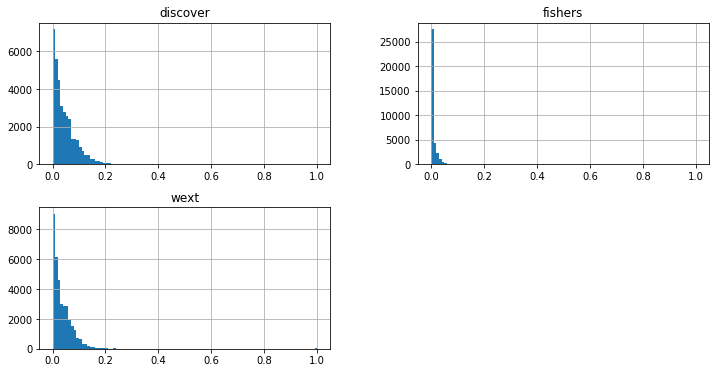

In [146]:
df_fishers.hist(bins=100, figsize=(12,6))

In [122]:
df_fd_temp = df_fishers[(df_fishers['gene1'].isin(genes_fisher_minus_discover)) | (df_fishers['gene2'].isin(genes_fisher_minus_discover))]
df_fd_temp

gene1   gene2  discover   fishers      wext
1        ERBB2   ERBB3  0.004723  0.001271  0.005530
6          EGF    EGFR  0.098567  0.051325  0.093591
8          CBL    EGFR  0.053819  0.027461  0.059483
9       PIK3R1  PIK3CA  0.029689  0.006245  0.020892
11       ERBB2    EGFR  0.068868  0.035382  0.071238
...        ...     ...       ...       ...       ...
12261    BCAS3   FBXW7  0.184834  0.099994  0.156028
12281     BAG6    TP63  0.001324  0.000182  0.001189
12291     HRAS  PIK3CA  0.077808  0.032583  0.065388
12302     ABL2     HCK  0.100859  0.052698  0.095387
12310  CYSLTR2   GRIK1  0.058160  0.029781  0.062970

[897 rows x 5 columns]

In [105]:
df_fd_temp.median()

discover    0.043623
fishers     0.000837
wext        0.033988
dtype: float64

In [106]:
df_fw_temp=df_fishers[(df_fishers['gene1'].isin(genes_fisher_minus_wext)) | (df_fishers['gene2'].isin(genes_fisher_minus_wext))]
df_fw_temp

gene1     gene2  discover       fishers      wext
7        AXIN1     GSK3B  0.019813  5.230871e-05  0.014366
13     SH3KBP1       CBL  0.009350  5.510359e-05  0.007326
27         CBL      EGFR  0.028281  3.330877e-04  0.021820
28        RAF1      BRAF  0.106570  1.354277e-03  0.084501
40       LRRK2       MSN  0.029159  2.168530e-05  0.019173
...        ...       ...       ...           ...       ...
36241   SETDB1     AIFM1  0.002267  6.356170e-08  0.000989
36264    RBM10    UBQLN4  0.062378  4.185293e-03  0.049768
36275    EWSR1     EPAS1  0.097671  2.405010e-02  0.079253
36287     LCOR     EWSR1  0.032393  1.525871e-03  0.026993
36289    CDC73  KIAA1549  0.036336  6.391010e-05  0.025755

[1228 rows x 5 columns]

In [107]:
df_fw_temp.median()

discover    0.044105
fishers     0.000977
wext        0.034816
dtype: float64

In [99]:
count = 0
for idx,row in df_fw_temp.iterrows():
    d = row['discover']
    f = row['fishers']
    w= row['wext']
    
    if f>d or f>w:
        count+=1
count

0